<a href="https://colab.research.google.com/github/RiverTwilight/Neural_Network/blob/master/Neural_Network_Full_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

> Created by **Rene Wang**

This is a full example of how to detect hand-writting number with deep learning. The example is based on the MNIST dataset, which contains 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image of a hand-written digit. The goal is to train a model to correctly classify the digit in the image.

<a href="https://colab.research.google.com/drive/18B-Fujnr7uDhfyERZzWHTI3-31anw5OH?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colorama
is_training = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset Process

This will transform the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). You can use this [script]() to generate augumented dataset with applying little translate and rotataion to the exsited data.

### Use Custom Dataset

In [ ]:
#@title Custom Data Config
min_therehold = 127 #@param {type:"number"}
max_therehold = 255 #@param {type:"number"}

In [ ]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

train_data_path = '/content/drive/MyDrive/Project/NeuralNetwork/data/train'
test_data_path = '/content/drive/MyDrive/Project/NeuralNetwork/data/test'

def read_file(data_path, one_hot_label, flatten=False):
    img_size = 784

    x_train = []
    t_train = []

    for foldername in os.listdir(data_path):
        bundle_path = os.path.join(data_path, foldername)
        if os.path.isdir(bundle_path):
            images = []  # list to store all images in the bundle
            for file_name in os.listdir(bundle_path):

                file_type = str(file_name.split('.')[1])
                if file_type != "png" and file_type != "jpg":
                    continue

                img = cv2.imread(os.path.join(bundle_path, file_name))
                label = int(file_name[0])

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                retval, dst = cv2.threshold(gray, min_therehold, max_therehold, cv2.THRESH_OTSU)

                dst = dst.astype(np.float32)

                flattened_img = dst.flatten()
                flattened_img = 255 - flattened_img

                img_processed = flattened_img.reshape(dst.shape)
                
                images.append(cv2.resize(img_processed, (28, 28)))  # add resized image to bundle

                flattened_img /= 255.0

                x_train.append(flattened_img)

                if one_hot_label:
                    one_hot = [0] * 10
                    one_hot[label] = 1
                    t_train.append(one_hot)

                else:
                    t_train.append(label)
                    
            # concatenate images horizontally and display the result
            if len(images) > 0:
                print(bundle_path)
                bundle_img = cv2.hconcat(images)
                cv2_imshow(bundle_img)

    x = np.array(x_train)
    t = np.array(t_train)

    return (x, t)

def load_custom_data(one_hot_label=False):
    return read_file(train_data_path, one_hot_label), read_file(test_data_path, one_hot_label)


### Use MINIST dataset

In [ ]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import numpy as np
import sys, os
sys.path.append('/content/')

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# dataset_dir = os.path.dirname(os.path.abspath("/content"))
dataset_dir = "/content"
dataset_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(dataset_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """读入MNIST数据集
    
    Parameters
    ----------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label : 
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组
    
    Returns
    -------
    (训练图像, 训练标签), (测试图像, 测试标签)
    """
    if not os.path.exists(dataset_file):
        init_mnist()
        
    with open(dataset_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


# Functions



## Basic Funtions

In [ ]:
# Activation Function
import matplotlib.pyplot as plt

def step(x):
    y = x > 0
    return y.astype(int)

print(step(np.array([1, 3, 0])))

# Old and widely-used activation function.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

# There are three common places of these three activation function:
#
#  1. The output is between 0 to 1
#  2. Both is liner function
#  3. The more important the input is, the bigger the output is.

x = np.array([1, 2])
w = np.array([[3, 4], [5, 2]]) # The row number should equal to x's length.

# Diffrent operation order will output diffrenet result
print(np.dot(w, x)) # [11, 9]
print(np.dot(x, w)) # [13, 8] [1 x 3 + 2 x 5, 1 x 4 + 2 x 4]

# Central Difference Derivation
# We use 2 h to reduce the deviation.
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)

def func_1(x):
    return 0.01 * x ** 2 + 0.1 * x

x = np.arange(0.0, 20.0, 0.1)
y = numerical_diff(func_1, x) # This is a valid operation (boardcast)

try:
    is_training
except:
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x, y)
    plt.show()

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # e ^ (a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

def softmax_batch(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

[1 1 0]
[11  9]
[13  8]


## Cross Entropy Error

We want the loss function result as small as possible.

We introduce loss function to find a params that generate small loss function result.

In [ ]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))
    
def cross_entropy_error_batch(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    # Only output the index of the right anwser.
    if t.size == y.size:
        t = t.argmax(axis=1) # 1 is the max
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


# Graident

In vector calculus, the gradient of a scalar-valued differentiable function 
$ f $ of several variables is the vector field (or vector-valued function) f whose value at a point is the "direction and rate of fastest increase".

The most basic way to find the gradient is to use the numerical differentiation method.

$$  grad(x, y) = \frac{f(x + h) - f(x - h)}{2h} $$

```python
import numpy as np

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   

def test_function(x):
    return x[0] ** 2 + x[1] ** 2

def gradient_desent(f, init_x, lr=0.01, step_num=100):
    """
    lr is Learning Rate. This should not be too large or too small.
    """

    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x
```

There are four mainstream gradient desend algorithum.

In [ ]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 还原值
        it.iternext()   

## SGD (Stochastic Gradient Descent)

We can get new weights by:

$$ W \leftarrow W - \eta \frac{\delta L}{\delta W} $$

$ \eta $ is the learning rate, and $ \frac{\delta L}{\delta W} $ is the gradinent of $ W $

The SGD sucks when the function is not anisotropic.


In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key, val in params.items():
            params[key] -= self.lr * grads[key]

## Momentum

This method can make the gradient reach the extreme position faster

In [ ]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


## AdaGrad

AdaGrad (Adaptive Gradient) is an algorithm for gradient-based optimization that adapts the learning rate component-wise to the parameters by incorporating knowledge of past observations. It introduces the **learning rate decay** method. Compared with the momentum method, this method will gradually reduce the learning rate.

$$\Delta w_t = - \frac{\eta}{\sqrt{\sum_{i=1}^{t} g_{i}^2 + \epsilon}} g_t$$



In [ ]:
class AdaGrad:
    def __init__(self, learning_rate=0.01, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.cache = {}

    def update(self, params, gradients):
        if not self.cache:
            for key, value in params.items():
                self.cache[key] = np.zeros_like(value)

        for key in params.keys():
            self.cache[key] += gradients[key] * gradients[key]
            params[key] -= (self.learning_rate * gradients[key] / (np.sqrt(self.cache[key]) + self.epsilon))

        return params


## Adam

In [ ]:
class Adam:
    def __init__():
        pass

# Layers

## Relu

Return x if x is larger than 0, otherwise return 0.

$$
Relu(x) = \left\{
    \begin{array}\\
        1 & \mbox{if } \ x > 0 \\
        0 & \mbox{otherwise }
    \end{array}
\right.
$$

In [ ]:
class Relu:
    def __init__(self) -> None:
        self.mask = None
    
    def forward(self, x):
        """
        x should be a numpy array here
        """
        self.mask = (x <= 0) # An array represting wheather each element is larger than 0. [True, False, False]
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        """
        Set all the `Ture` in mask to 0
        """
        dout[self.mask] = 0
        dx = dout

        return dx

## Affine

$$
Affine(x) = X • W + b
$$

In [ ]:
class Affine:
    def __init__(self, W, b) -> None:
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        x = x.reshape(x.shape[0], -1)
        dot = np.dot(self.x, self.W)
        out = dot + self.b # Boardcasting...

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

## SoftmaxWithLoss

The Softmax Loss is a widely used loss function in the field of deep learning. It is also referred to as the Cross-entropy loss with softmax.

Let us consider the training data, denoted as 't', which is assumed to have undergone one-shot training, represented as follows:

 $$ t = (0, 0, 0, ..., 1, 0) $$

Here, $ t_{k} $ corresponds to the correct answer. The predicted result, denoted by $ z $, can be expressed as:

 $$ z = (z_{1}, z_{2}, ..., z_{C}) $$

The corresponding loss function, 'lz', can be formulated as:

 $$ l_{z} = \sum_{i=1}^{C} t_{i} log(z) = -log(z_{k})$$

In comparison to a linear function, the logarithmic function better represents our desired objective.

In [ ]:
class SoftmaxWithLoss:
    def __init__(self, print_result=False) -> None:
        self.loss = None
        self.print_result = print_result
        self.y = None
        self.x = None

    def forward(self, x, t):
        self.t = t 
        # Teaching Data. Marking the right answer.
        # Set right anwser to 1 and wrongs to 0. For exmaple, [0, 0, 0, 1, 0, 0]

        self.y = softmax_batch(x)
        self.loss = cross_entropy_error_batch(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## Batch Normalization

 $$ l_{B} \leftarrow \frac{1}{m}\sum_{i=1}^{m} x_{i} $$

## Dropout

Dropout layer will randomly delete some points. Since the network differs every time, it's similar with intergrate-learning(Use multiple models to learn and get the average).

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
    
    def forward(self, x, train_flg=True):
        if train_flg:
            # Replace the item large than ratio. [True, True, False, ..., True]
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        # Same with Relu
        return dout * self.mask


## Convolution 

In [ ]:
class Convolution:
    def __init__(self, W):
        self.W = W

## Pooling

# Network


## Multi-layer Net

This network reach a accuarcy of 97%

In [ ]:
import numpy as np
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_sizes, output_size, weight_init_std=0.01, initParams=None, weight_decay_lambda=0, use_dropout=False, dropout_ratio=0) -> None:
        
        self.params = {}
        self.weight_decay_lambda = weight_decay_lambda
        self.hidden_layer_count = len(hidden_sizes)

        if initParams is not None:
            self.params = initParams
        else:
            self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_sizes[0])
            self.params['b1'] = np.zeros(hidden_sizes[0])

            for i in range(1, self.hidden_layer_count):
                self.params[f'W{i+1}'] = weight_init_std * np.random.randn(hidden_sizes[i-1], hidden_sizes[i])
                self.params[f'b{i+1}'] = np.zeros(hidden_sizes[i])

            self.params[f'W{self.hidden_layer_count+1}'] = weight_init_std * np.random.randn(hidden_sizes[-1], output_size)
            self.params[f'b{self.hidden_layer_count+1}'] = np.zeros(output_size)

        self.layers = OrderedDict()
        
        for i in range(self.hidden_layer_count):
            self.layers[f'Affine{i+1}'] = Affine(self.params[f'W{i+1}'], self.params[f'b{i+1}'])
            self.layers[f'Relu{i+1}'] = Relu()
            
            if use_dropout:
                self.layers[f'Dropout{i+1}'] = Dropout(dropout_ratio)

        self.layers[f'Affine{self.hidden_layer_count+1}'] = Affine(self.params[f'W{self.hidden_layer_count+1}'], self.params[f'b{self.hidden_layer_count+1}'])

        self.lastLayer = SoftmaxWithLoss(print_result = (not initParams == None))

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)

        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        
        # Get the index of the maximum value. If one-shot is enabled the max value is 1
        # For example, [[1, 0, 0], [0,0,1]] will be converted to [0, 2]
        if t.ndim != 1: t = np.argmax(t, axis=1)

        # if x.shape[0] <= 50:
        #     print("Expected Anwser: " + str(t))
        #     print("Exact Anwser: " + str(y))

        accuracy = np.sum(y == t) / float(x.shape[0])

        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for i in range(self.hidden_layer_count + 1):
            grads[f"W{i+1}"] = self.layers[f"Affine{i+1}"].dW + self.weight_decay_lambda * self.layers[f"Affine{i+1}"].W
            grads[f"b{i+1}"] = self.layers[f"Affine{i+1}"].db

        return grads

## CNN

Convolutional neural networks is an enhanced version, which offers significant advantages, most notably the preservation of data shape. In previous neural network architectures, it was often necessary to convert two-dimensional arrays to one-dimensional arrays. 

With CNN, however, original-shaped data can be directly inputted into the network, without the need for additional preprocessing steps. As a result, CNNs outperform other neural network architectures, particularly when processing colored images.

$\nabla F=\begin{pmatrix} yz \ xz \ xy \end{pmatrix}$

# Training

It's unusual for the accuracy to plateau after only a few epochs, especially if you're using a relatively large dataset.

## Optimization

* Use Dropout
* Use weight decay
* Enlarge the training dataset

In [ ]:
#@title Training Config { run: "auto" }

scene = "Train" #@param ["Train", "Production"]
network_type = "MultiLayer" #@param ["MultiLayer", "CNN"]
learning_rate = 0.01 #@param {type:"number"}
batch_size =100 #@param {type:"number"}
hidden_layers = 2 #@param {type:"slider", min:0, max:10, step:1}
layer_size = 100 #@param {type:"number"}
iters_num = 25000 #@param {type:"slider", min:5000, max:100000, step:5000}
optimizer_type = "Momentum" #@param ["SGD", "Momentum", "AdaGrad", "Adam"]
train_data_source = "MINIST + Custom" #@param ["MINIST", "MINIST + Custom"]
test_data_source = "Custom" #@param ["MINIST", "Custom", "MINIST + Custom"]
weight_decay_lambda = 0.05 #@param {type:"slider", min:0, max:0.3, step:0.01}
use_dropout = False #@param {type:"boolean"}
dropout_ratio = 0.1 #@param {type:"slider", min:0, max:0.3, step:0.01}
load_params = False #@param {type:"boolean"}

/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_0


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_1


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_3


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_2


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_2_1


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_2_2


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_2_0


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_2_3


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_3_0


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_2_4


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_3_2


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_0_2


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_3_1


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_0_1


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_3_4


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_3_3


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_0_0


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_0_3


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_0_4


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_1_0


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_1_4


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_1_1


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_1_3


/content/drive/MyDrive/Project/NeuralNetwork/data/train/bundle_1_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_3


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_1


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_4


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_0


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_2_1


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_1_4


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_1_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_0_3


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_1_3


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_1_1


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_1_0


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_2_0


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_0_4


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_2_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_2_3


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_3_1


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_3_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_4_1


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_3_3


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_4_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_4_0


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_3_0


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_2_4


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_3_4


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_4_3


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_0_2


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_0_0


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_0_1


/content/drive/MyDrive/Project/NeuralNetwork/data/test/bundle_4_4


● Entering Train Mode...
x_train size: (60228, 784)
x_test size: (309, 784)


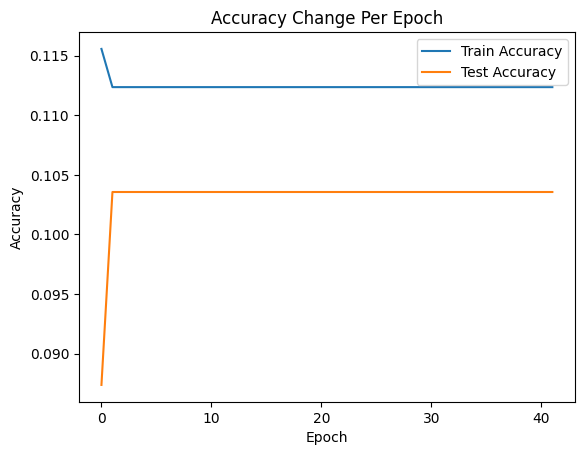

TypeError: ignored

In [ ]:
import pickle
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import math

hidden_sizes = [layer_size for _ in range(hidden_layers)]

def train(x_train, t_train, x_test, t_test, initParams=None):

    network = TwoLayerNet(input_size=784, hidden_sizes=hidden_sizes, output_size=10, initParams=initParams, weight_decay_lambda=weight_decay_lambda, use_dropout=use_dropout, dropout_ratio=dropout_ratio)

    optimizer = None

    if optimizer_type == "SGD":
        optimizer = SGD(lr=learning_rate)
    elif optimizer_type == "Momentum":
        optimizer = Momentum(lr=learning_rate)
    elif optimizer_type == "AdaGard":
        optimizer = SGD()
    else:
        optimizer = SGD()

    train_size = x_train.shape[0] # 60000
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size) # Select a batch_size between 0 - train_size

        # Randomly select a part of data
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        if not initParams:
            grads = network.gradient(x_batch, t_batch)
            optimizer.update(network.params, grads)

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        # Only calcuate accuracy every epoch. All data passed in.
        if i % math.floor(iter_per_epoch) == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            # print(train_acc, test_acc)
    
    epochs = range(len(train_acc_list))
    plt.plot(epochs, train_acc_list, label='Train Accuracy')
    plt.plot(epochs, test_acc_list, label='Test Accuracy')
    plt.title('Accuracy Change Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # print("Max Test Accuracy: " + Fore.BLUE + str(np.maximum(test_acc_list)) + Fore.reset)
    
    return network.params

param_cache = None
param_cache_dir = "/content"
param_cache_file = param_cache_dir + "/params.pkl"

if os.path.exists(param_cache_file):
    with open(param_cache_file, 'rb') as f:
        param_cache = pickle.load(f)

minist_dataset = load_mnist(normalize=True, one_hot_label=True)
custom_dataset = load_custom_data(one_hot_label=True)

if train_data_source == "MINIST":
    (x_train, t_train), _ = minist_dataset
elif train_data_source == "MINIST + Custom":
    (x_train_mnist, t_train_mnist), _ = minist_dataset
    (x_train_custom, t_train_custom), _ = custom_dataset
    x_train = np.concatenate((x_train_mnist, x_train_custom), axis=0)
    t_train = np.concatenate((t_train_mnist, t_train_custom), axis=0)

if test_data_source == "MINIST":
    _, (x_test, t_test) = minist_dataset
elif test_data_source == "MINIST + Custom":
    _, (x_test_mnist, t_test_mnist) = minist_dataset
    _, (x_test_custom, t_test_custom) = custom_dataset
    x_test = np.concatenate((x_test_mnist, x_test_custom), axis=0)
    t_test = np.concatenate((t_test_mnist, t_test_custom), axis=0)
elif test_data_source == "Custom":
    _ , (x_test, t_test) = custom_dataset

print(Back.GREEN + "● Entering " + scene +  " Mode..." + Back.RESET)

if scene == "Train":
    initParams = None

    if load_params and param_cache:
        initParams = param_cache
    
    print("x_train size: " + Fore.CYAN + str(x_train.shape) + Fore.RESET)
    print("x_test size: " + Fore.CYAN + str(x_test.shape) + Fore.RESET)
    
    params = train(x_train, t_train, x_test, t_test, initParams)

    if not load_params or not os.path.exists(param_cache_file):
        with open(param_cache_file, 'wb') as f:
            pickle.dump(params, f, -1)
            
elif param_cache:
    network = TwoLayerNet(input_size=784, hidden_sizes=hidden_sizes, output_size=10, initParams=param_cache, weight_decay_lambda=weight_decay_lambda)

    print("Results: " + Fore.YELLOW + str(np.argmax(network.predict(x_test), axis=1)) + Fore.RESET)
    print("Expects: " + Fore.GREEN + str(np.argmax(t_test, axis=1)))
    
else:
    print(Fore.YELLOW + "Please train params first")


## Reference

1. Saito Yasuhiro. Deep Learning from Scratch[M]. Japan: O'Reilly Japan, 2016.

2. 管他叫大靖. (2021年05月24日). Softmax Loss 的推导及改进. 知乎专栏. (https://zhuanlan.zhihu.com/p/374018199).

3. Khelifi Ahmed Aziz. Medium. Learn How to Write Markdown & LaTeX in The Jupyter Notebook (https://towardsdatascience.com/write-markdown-latex-in-the-jupyter-notebook-10985edb91fd)

3. Jay Gupta. Medium. Going beyond 99% — MNIST Handwritten Digits Recognition (https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392)